Advanced Lane Line Detection
===
#### Objective: Calibrating the Camera, Correct Distortion, Color and Gradient Threshold, Perspective Transform, Detect and Plot lanes

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from laneutils import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

CAL_IMG_PATH = "camera_cal/"
OUTPUT_PATH  = "output_images/"
TEST_IMG_PATH= "test_images/"
CAM_PICKLE_FILE = "camera_calibration.p"

# Create caliberation and Perspective Transform Object
caliberator_pt = CalibrateCamPerspectiveTransform(CAL_IMG_PATH,OUTPUT_PATH,CAM_PICKLE_FILE)

### 1. Caliberating the Camera
In the following cells we test caliberation on an original checkerboard image 
***

Loading from picked file...


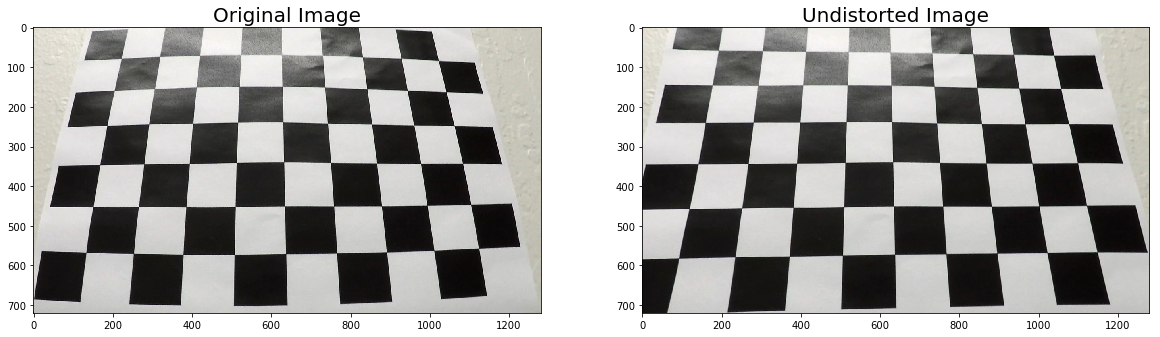

In [2]:
# Test undistortion on a caliberation image
img = mpimg.imread('camera_cal/calibration3.jpg')
undst = caliberator_pt.undistort(img,visualize = True)

#### **_Correcting Distortion_**
We test camera caliberation on a an actual image from dashcam video

Test image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3) before distortion correction


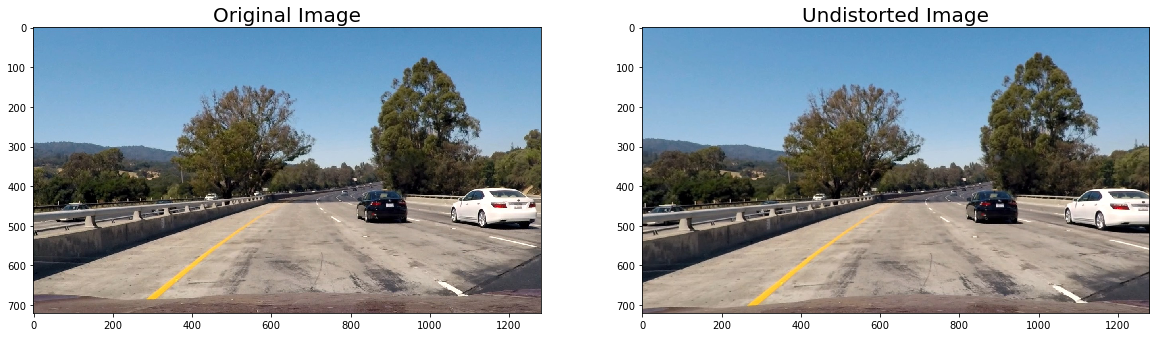

In [3]:
# Reading in an image
test_img = mpimg.imread('test_images/test1.jpg')
# Printing out some stats and plotting
print('Test image is:', type(test_img), 'with dimesions:', test_img.shape,'before distortion correction')
undst = caliberator_pt.undistort(test_img,visualize = True)

### 2. Binary Threshold of the Image
In the following code cells we show the binary threshold pipeline and masking
***

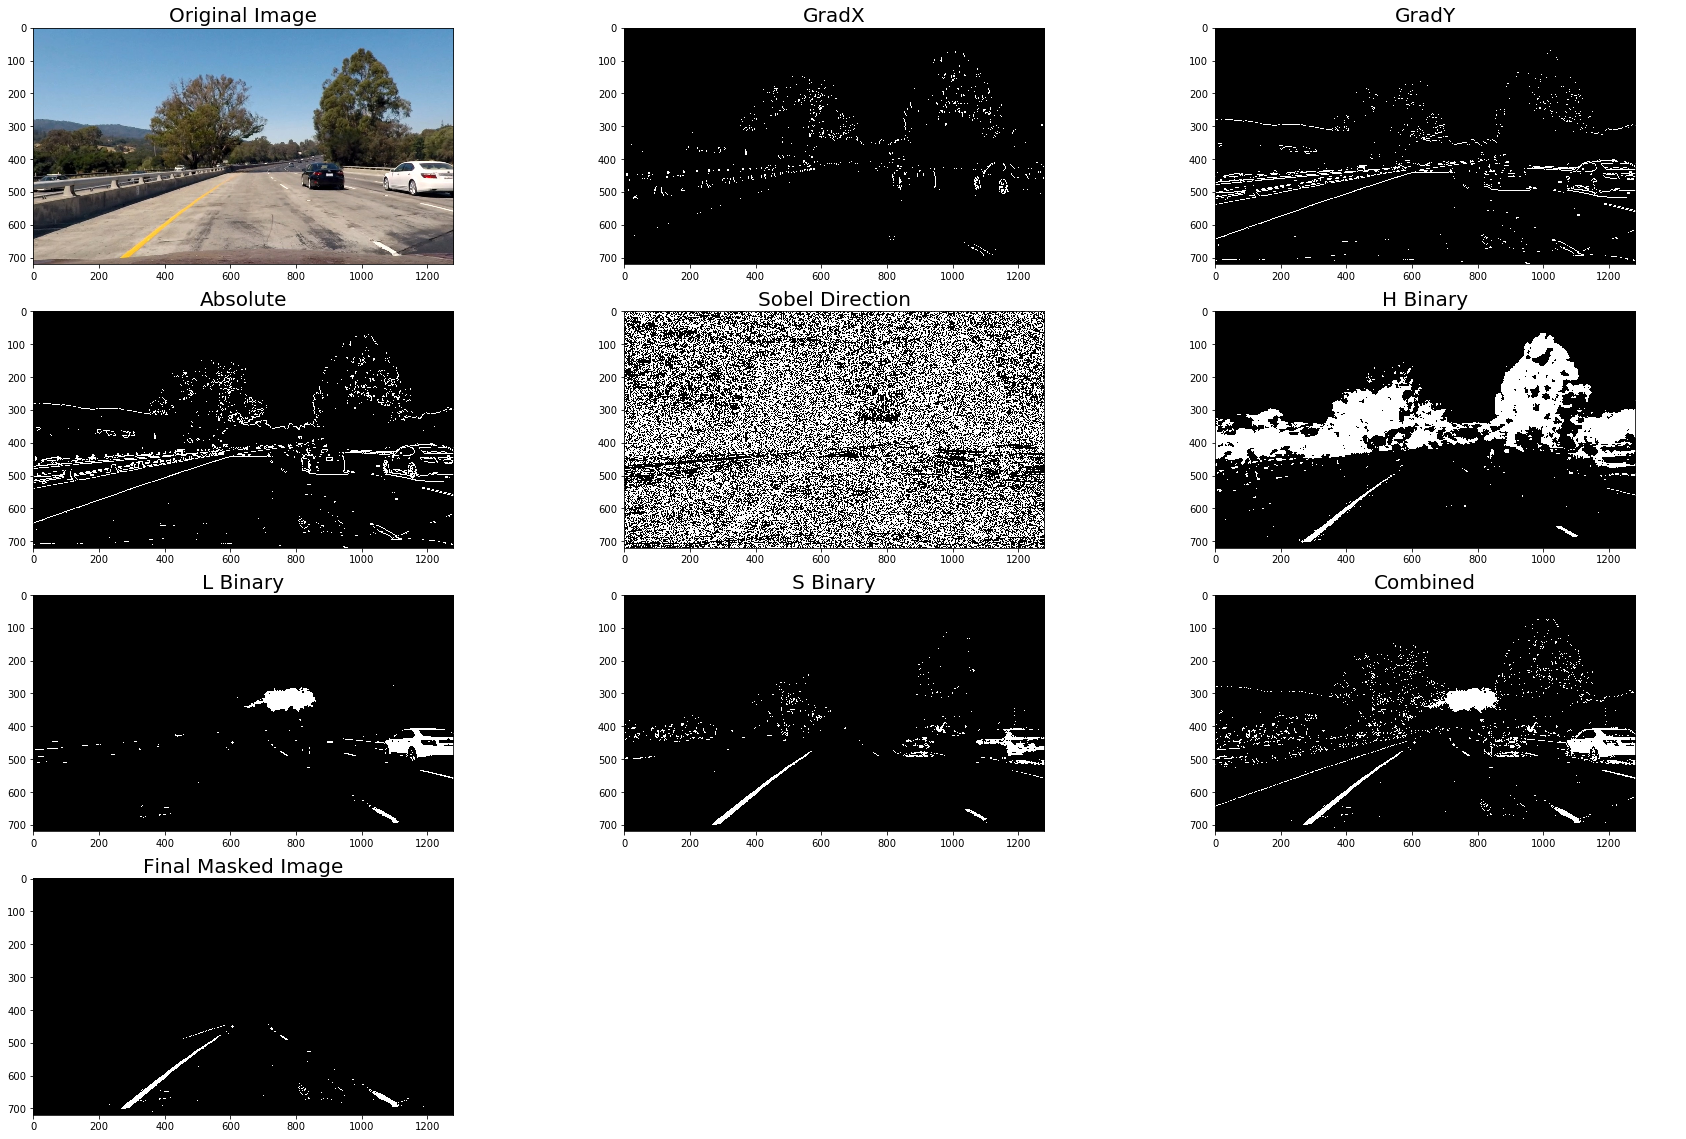

In [12]:
from laneutils import *
result =  threshold_pipeline(undst, show_pipeline = True)
mpimg.imsave('output_images/final_masked_img.jpg',result, cmap="gray")

**_Now we test the thresholding pipeline in sample images to see if the lanes can be seen well in the thresholded image_.**

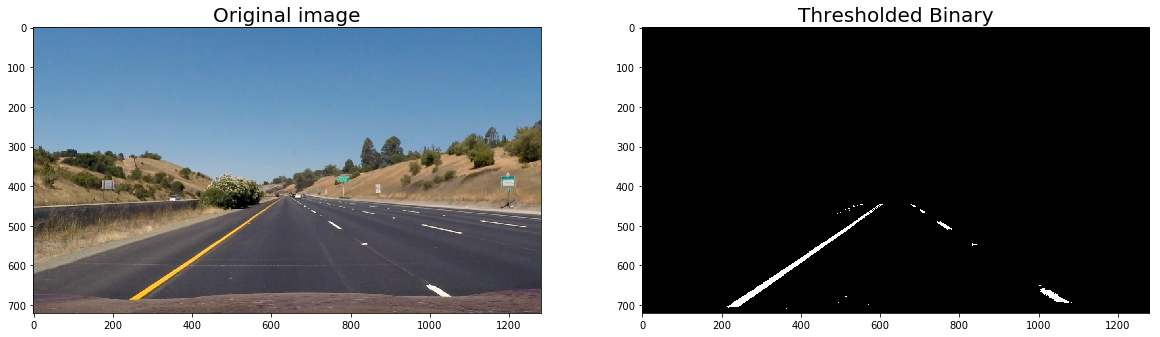

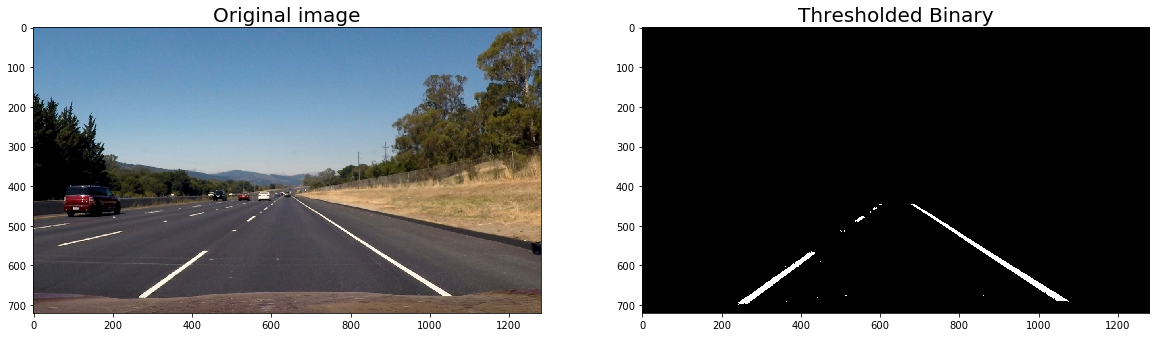

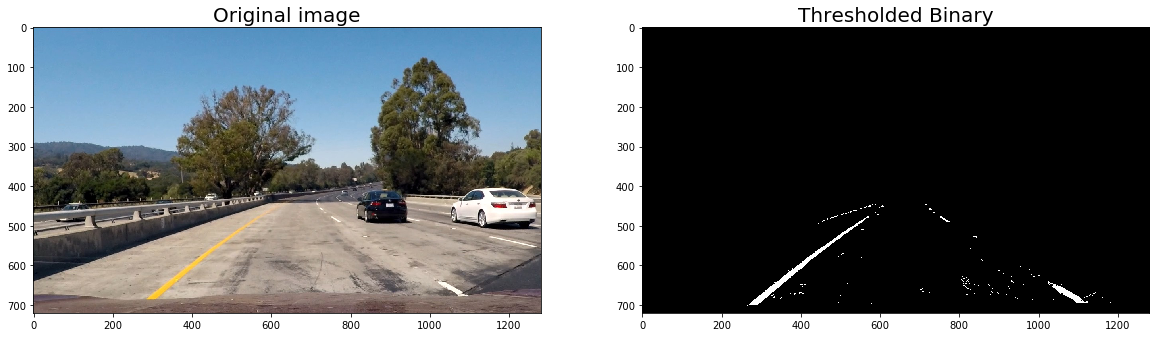

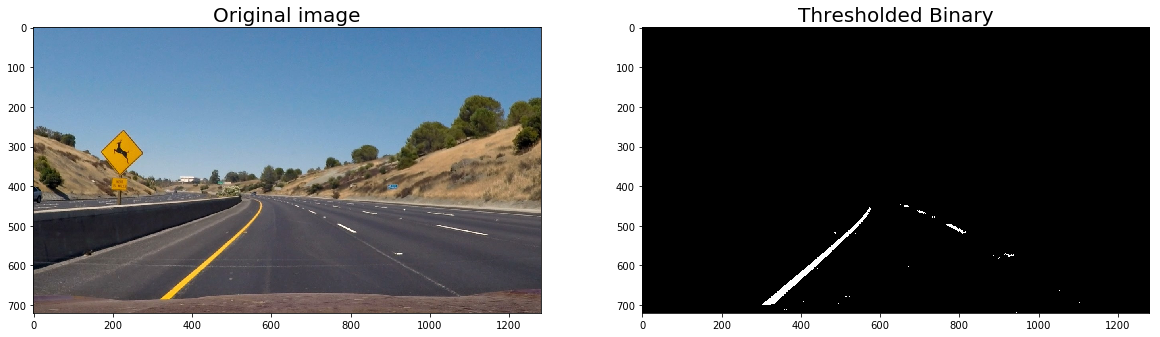

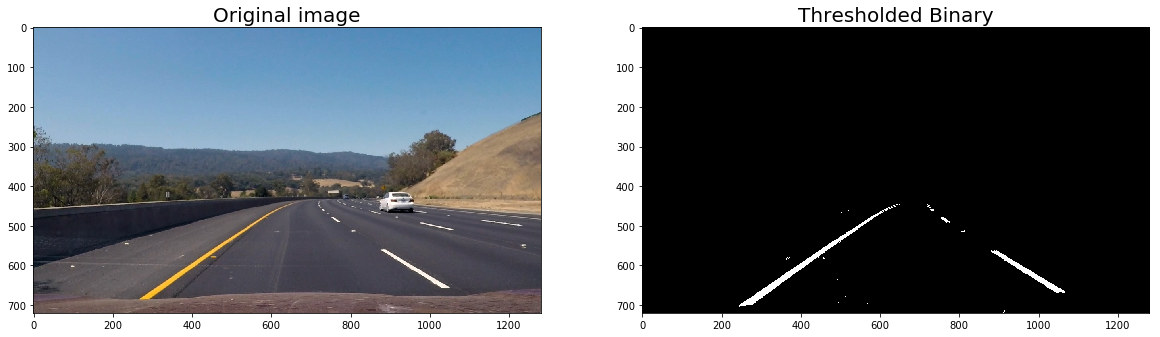

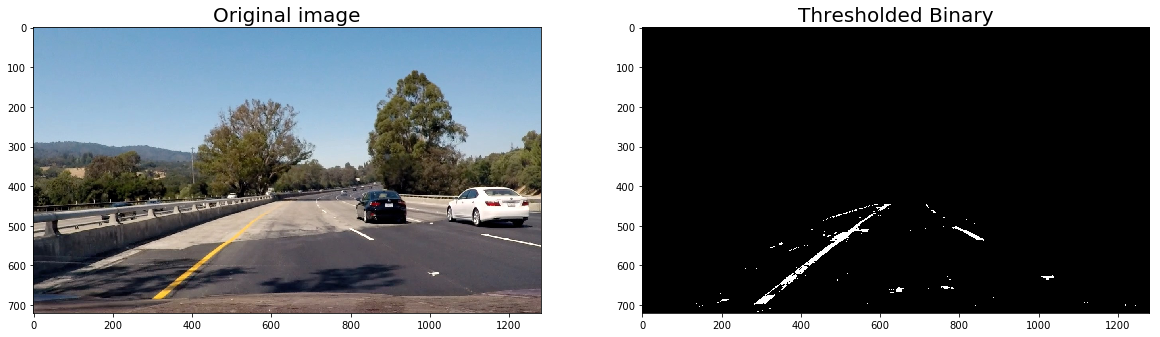

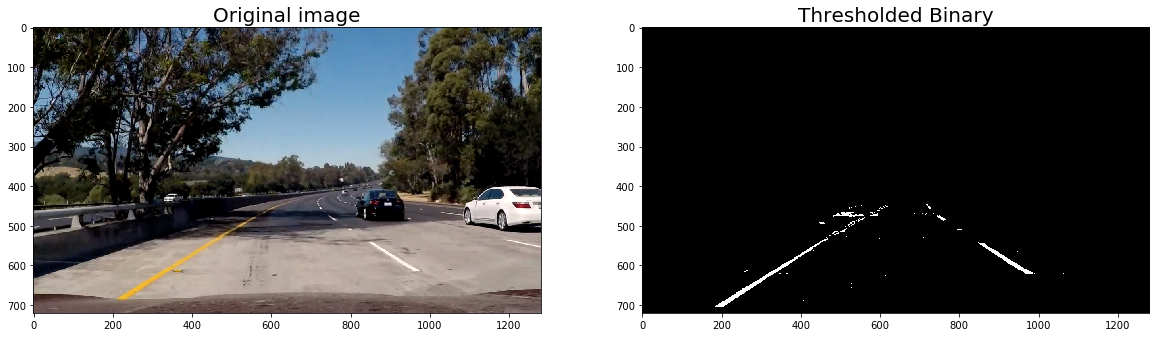

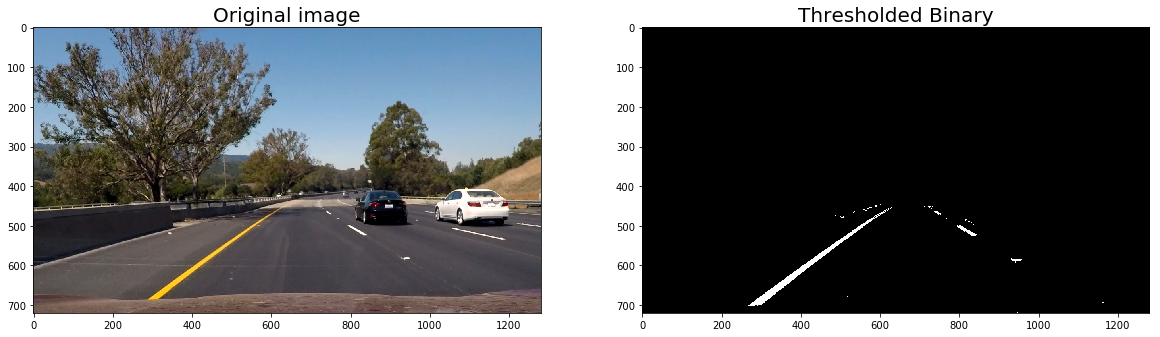

In [5]:
TEST_IMG_PATH="test_images/"
test_images_files = glob.glob(TEST_IMG_PATH+'*')
for test_image_file in test_images_files:
    test_img = mpimg.imread(test_image_file)
    result = threshold_pipeline(caliberator_pt.undistort(test_img), show_pipeline=False)
    show_images_sbs(test_img,result, "Original image", "Thresholded Binary")

### 3. Perspective Transform
In the following code cells we show how we obtained source and destination points in order to create bird's eye view of the lanes. We played around with many combinations of source and destination points to see which combination will give a proper bird's eye view of lanes in a sample image with straight lines
***

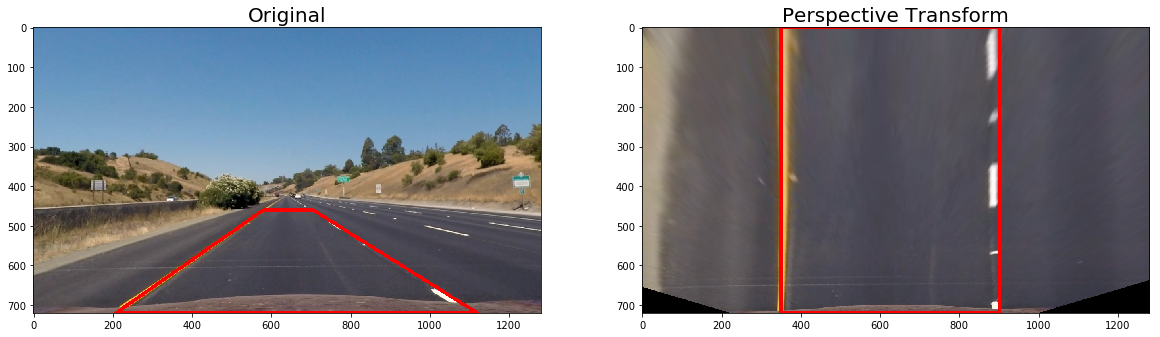

In [6]:
# Picking the src and dst points for Perspective Transform
test_img = mpimg.imread('test_images/straight_lines1.jpg')
test_img = caliberator_pt.undistort(test_img)
src = np.float32([[208,720],[580,460],[705,460],[1120,720]])
dst = np.float32([[350, 720],[350, 0],[900, 0],[900, 720]])
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(test_img, M, (test_img.shape[1], test_img.shape[0]), flags=cv2.INTER_LINEAR)
pts = np.array(src, np.int32).reshape((-1,1,2))
cv2.polylines(test_img,[pts],True,(255,0,0),cv2.LINE_8)
pts = np.array(dst, np.int32).reshape((-1,1,2))
cv2.polylines(warped,[pts],True,(255,0,0),cv2.LINE_8)
show_images_sbs(test_img,warped,'Original', 'Perspective Transform')

**_Now we test the perspective transform on sample images to see if the lanes can be seen parallel in warped image_.**

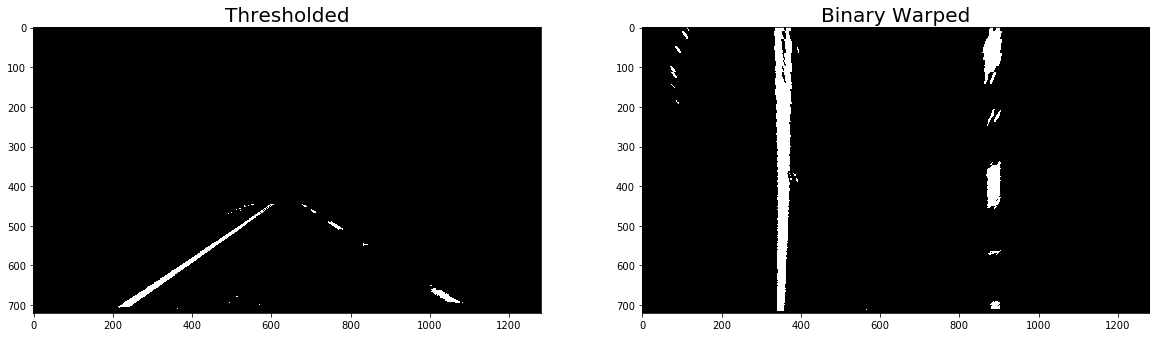

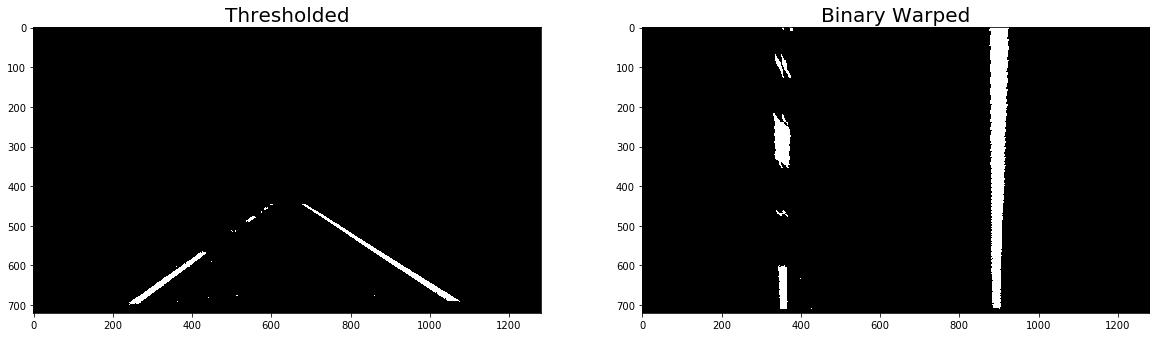

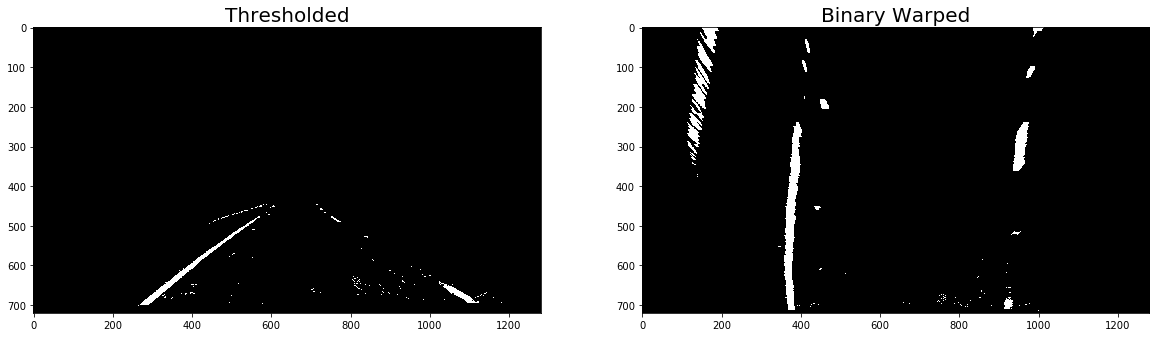

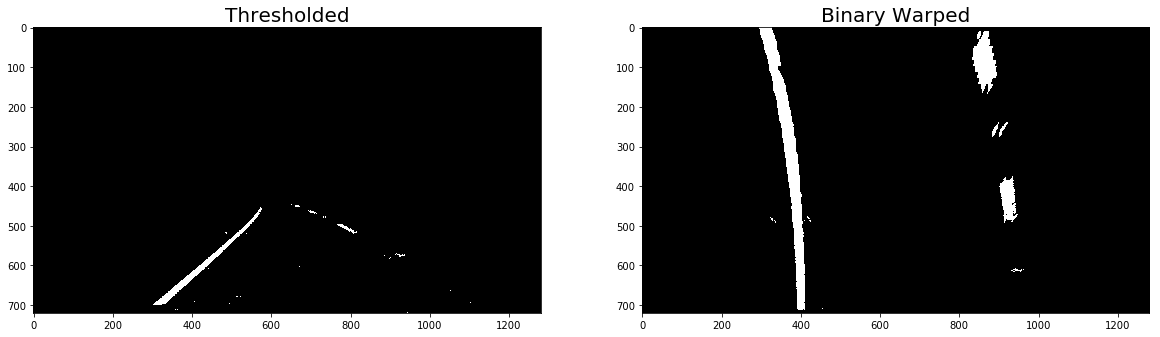

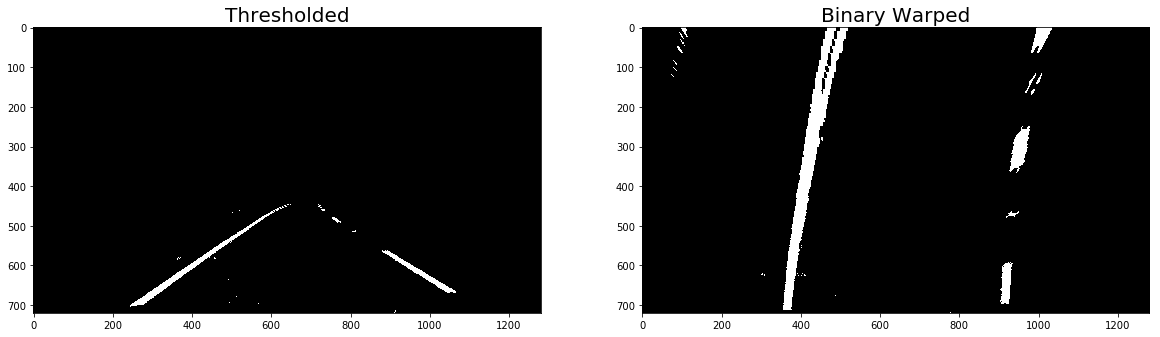

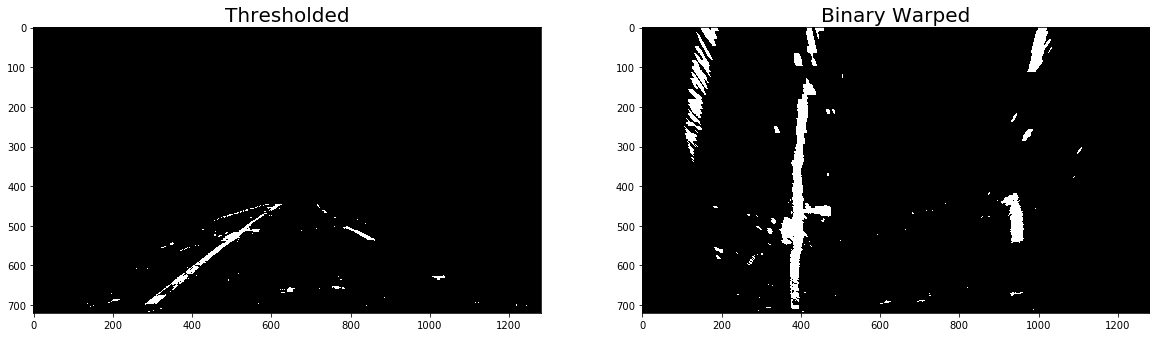

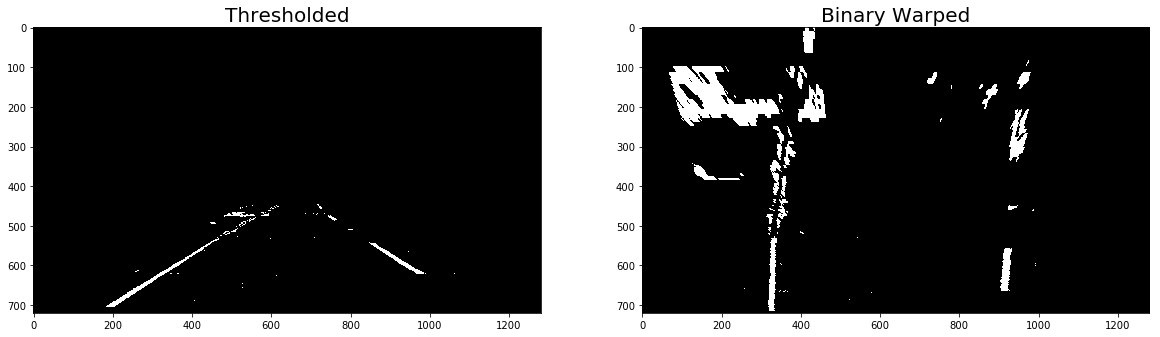

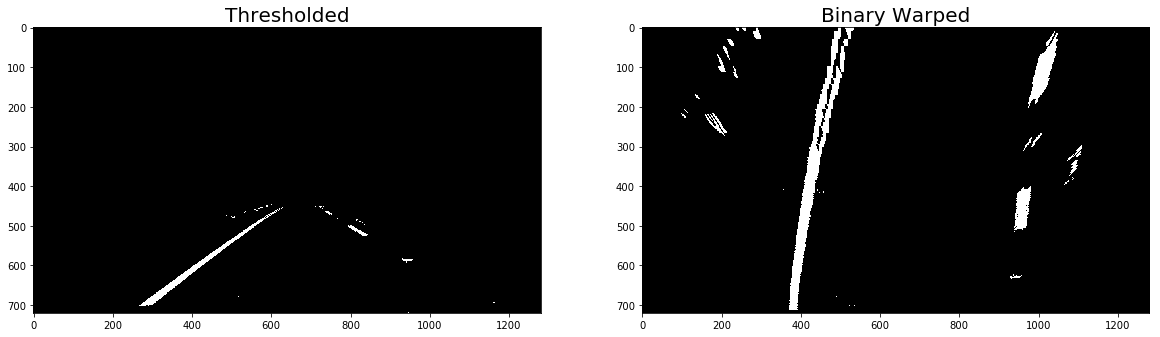

In [7]:
# Perspective Transform
TEST_IMG_PATH="test_images/"
test_images_files = glob.glob(TEST_IMG_PATH+'*')
for test_image_file in test_images_files:
    test_img = mpimg.imread(test_image_file)
    thresh_img = threshold_pipeline(caliberator_pt.undistort(test_img))
    binary_warped = caliberator_pt.warp(thresh_img)
    show_images_sbs(thresh_img,binary_warped,'Thresholded', 'Binary Warped')

### 4. Detect and Plot lanes: Put everything together
In the following cells we test the overall pipeline on a sample image to undistort, apply binary threshold and perspective transform, lane detection and finally mark detected lanes 
***

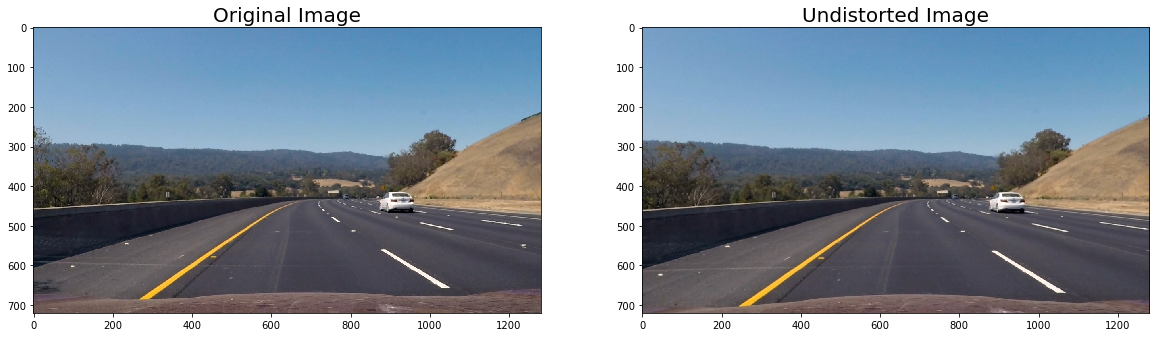

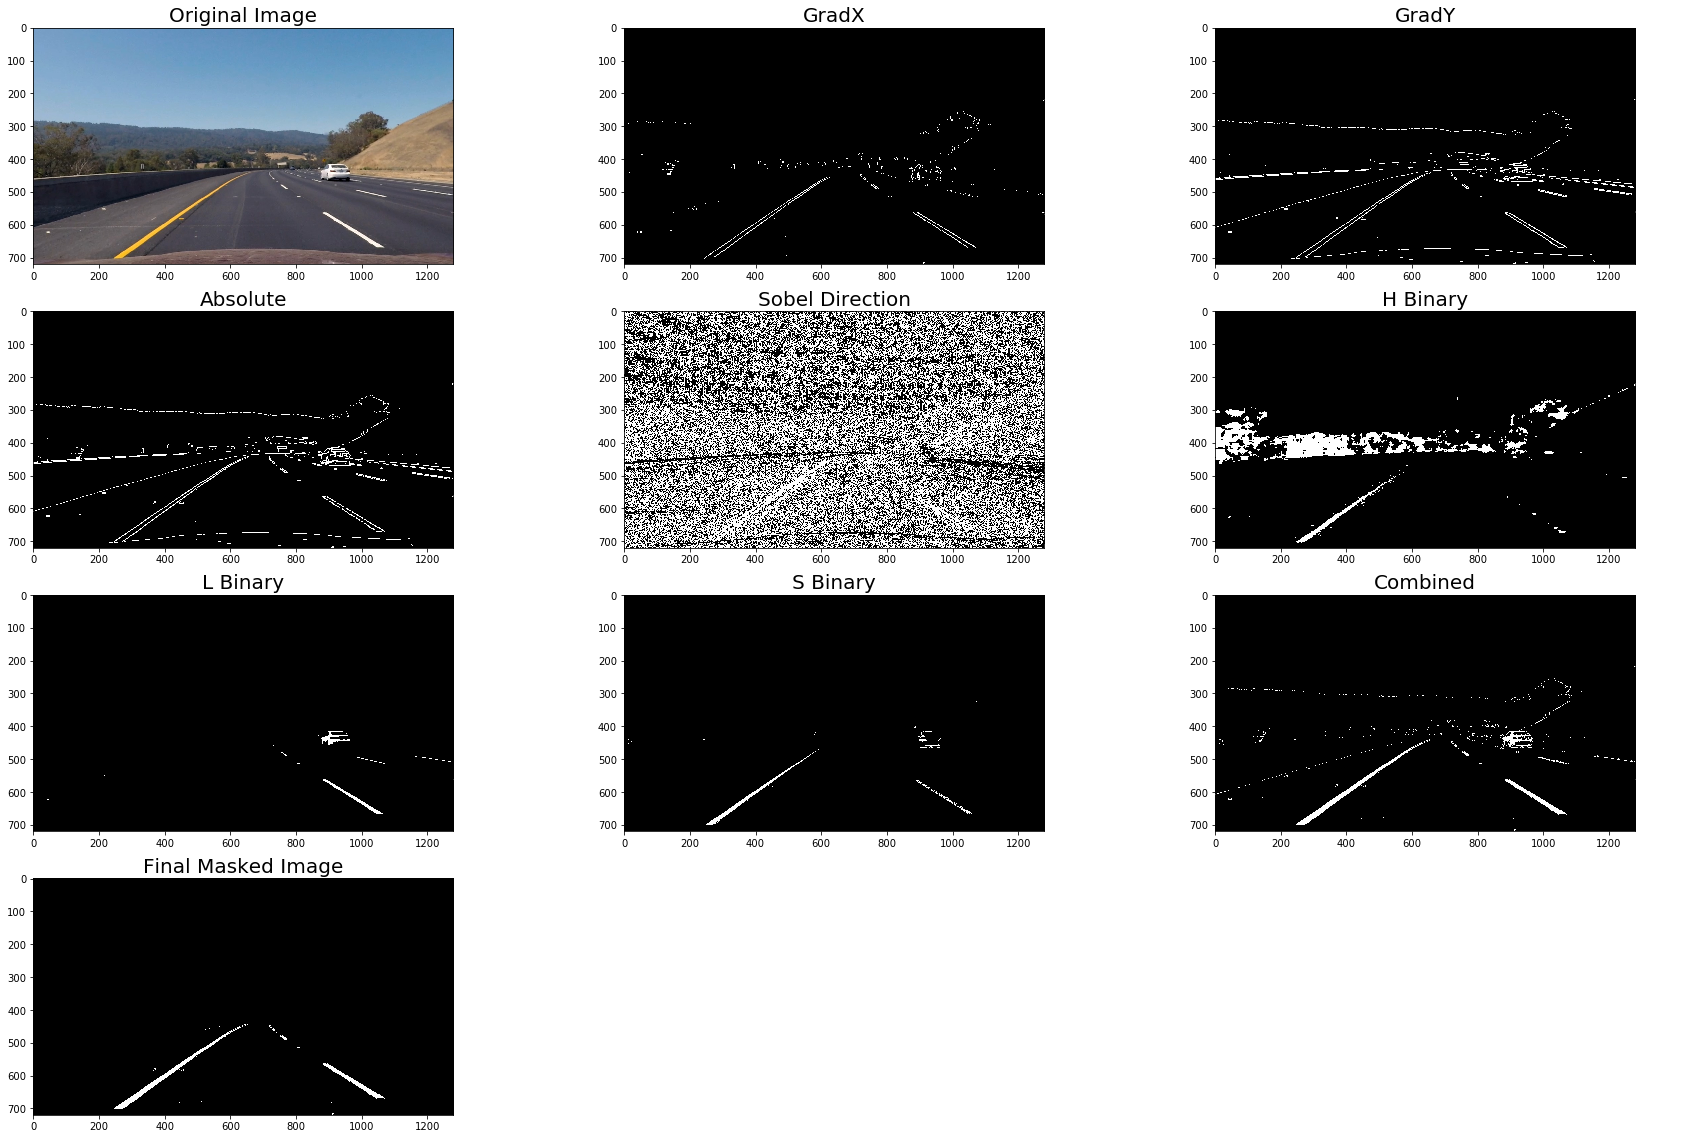

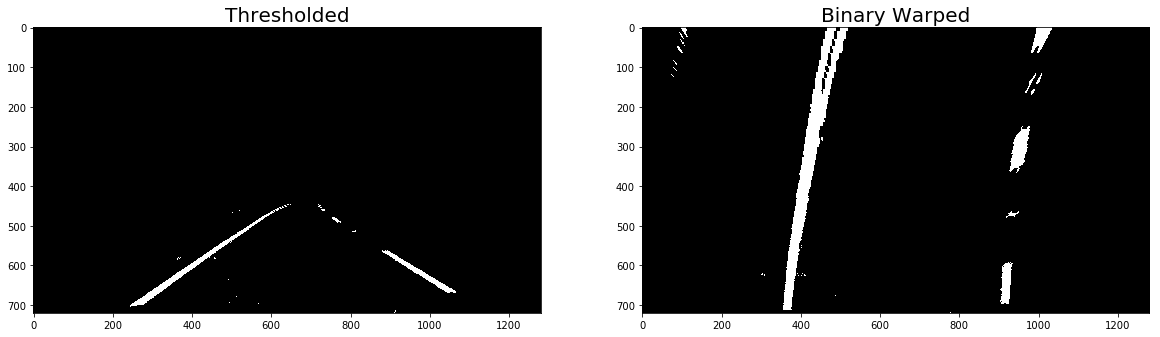

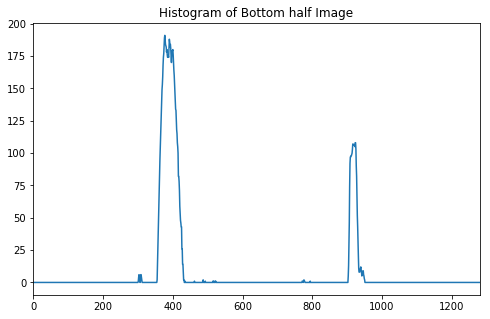

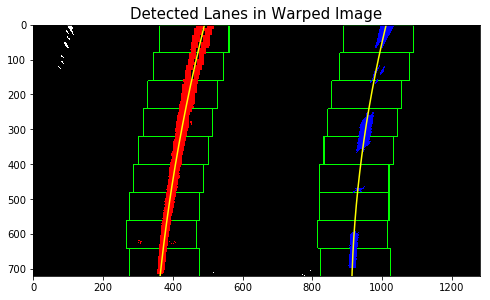

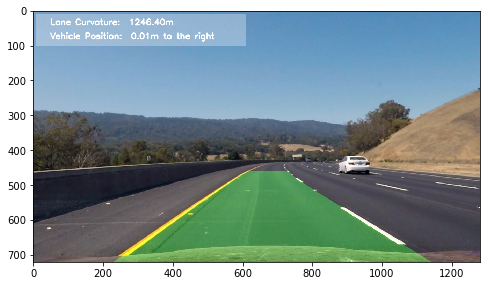

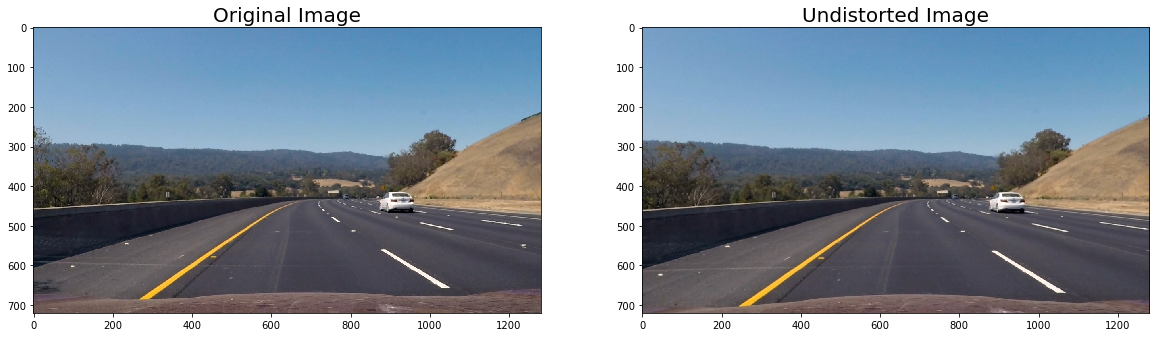

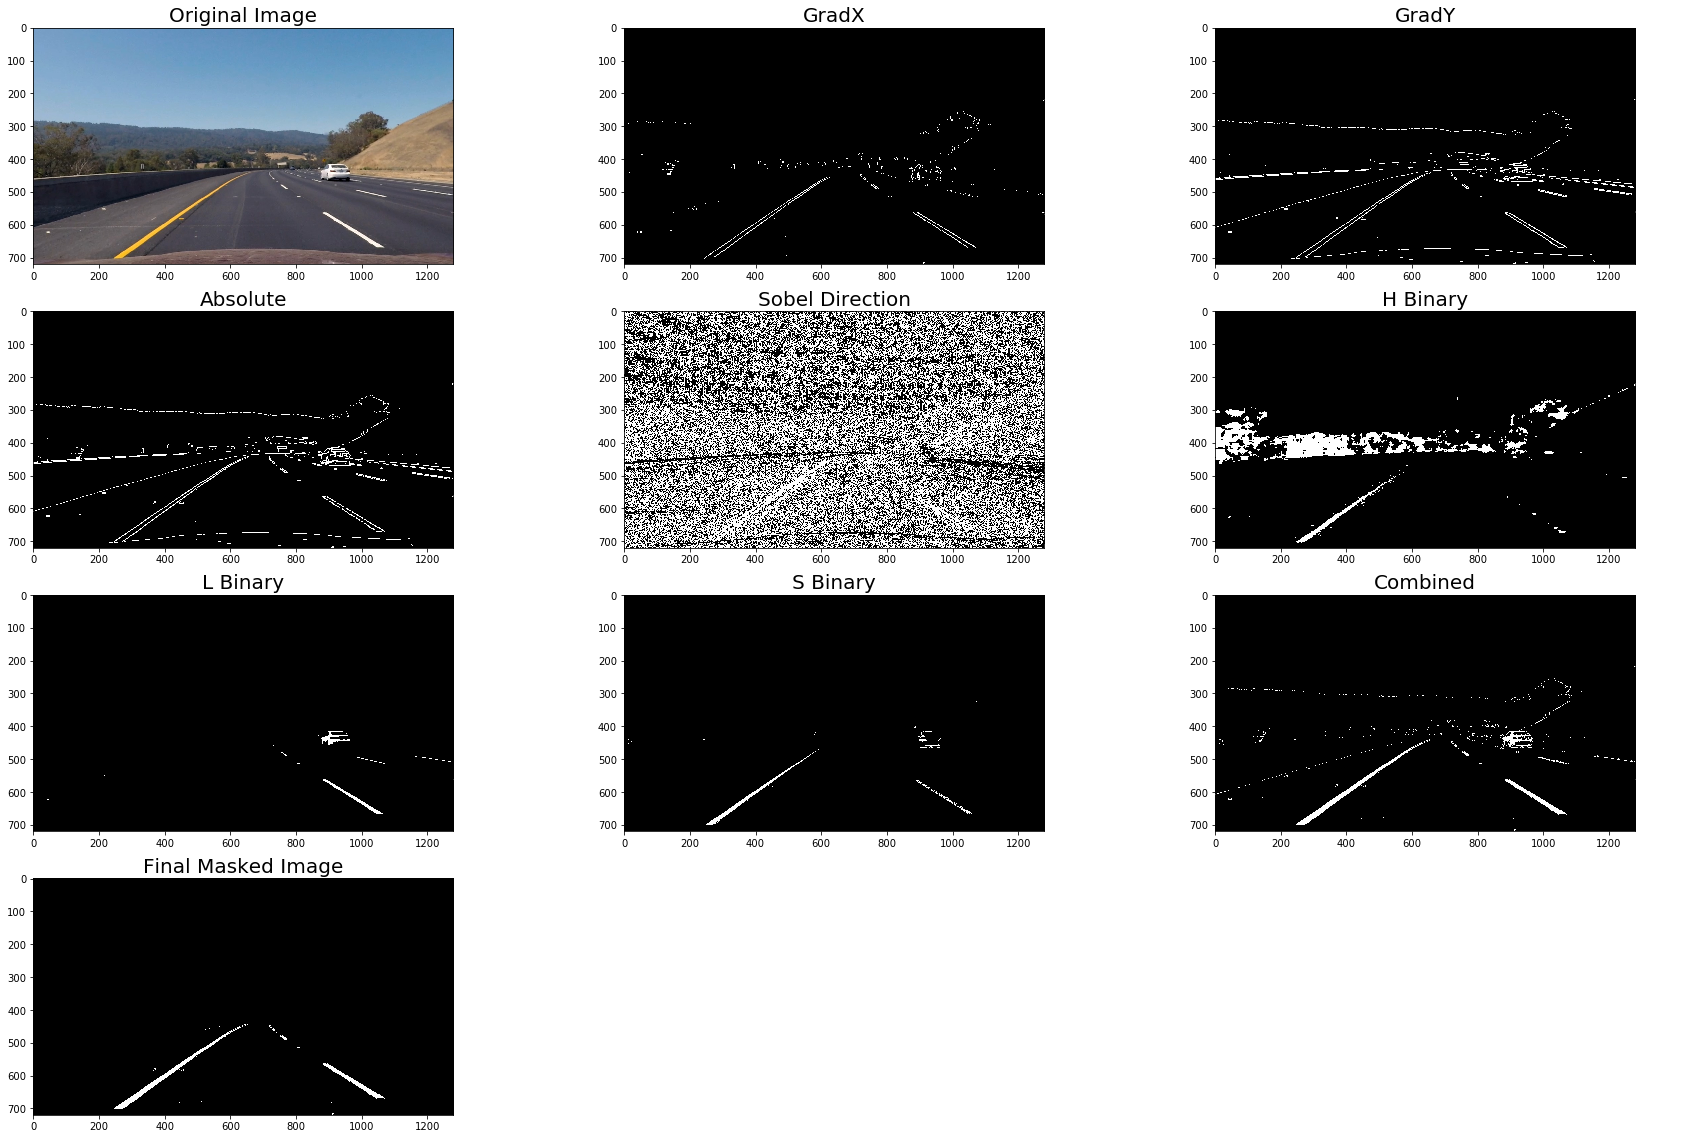

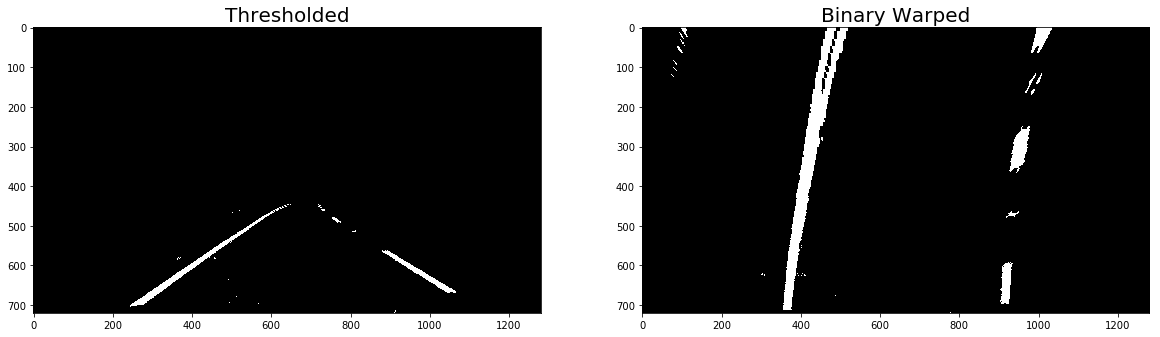

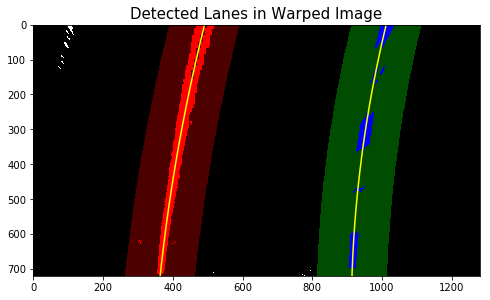

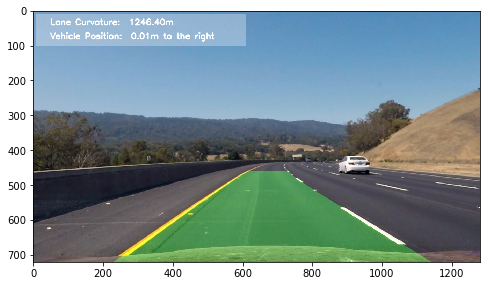

In [17]:
# Finding lane with histogram and sliding window. Please check laneutils.py for implementation
test_img = mpimg.imread('test_images/test3.jpg')
lane = LaneDetector(caliberator_pt, 5, debug=True)
output = lane.find_lane_img_frame(test_img)
show_single_image(output)

# Test again but this time no sliding window used since lane was detected in previous step
test_img = mpimg.imread('test_images/test3.jpg')
output = lane.find_lane_img_frame(test_img)
show_single_image(output)
mpimg.imsave('output_images/plot_lanes1.jpg',output)

**_Finally testing our pipleline on the project video_**

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
lane = LaneDetector(caliberator_pt, 5, debug=False)
input_video = "project_video.mp4"
output_video = input_video.split('.')[0]+"_with_marked_lanes.mp4"
clip1 = VideoFileClip(input_video)

white_clip = clip1.fl_image(lane.find_lane_img_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False, progress_bar=True, verbose=True)

[MoviePy] >>>> Building video project_video_with_marked_lanes.mp4
[MoviePy] Writing video project_video_with_marked_lanes.mp4


100%|█████████▉| 1260/1261 [06:24<00:00,  3.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_with_marked_lanes.mp4 

CPU times: user 19min 27s, sys: 2min 39s, total: 22min 7s
Wall time: 6min 25s


## Playing the video
Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))
# ipython_display("my_video.mp4")